In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
import numpy as np
import torch.nn.functional as F
from math import exp
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import math
import time
import torch.nn.utils as utils

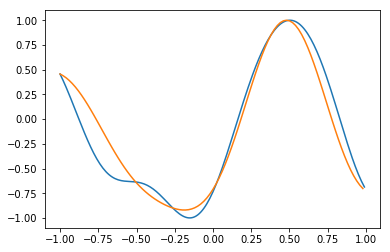

In [2]:
############################################
n=10000
xs = np.arange(-1.0, 1.0, 0.01)
xs_mf=np.arange(-1.0, 1.0, 0.02)
############################################
func = torch.load('traindata_50000.pt')
func_mf = torch.load('traindata_50000_fidelity2.pt')
func_t = torch.load('testdata_7000.pt')
func_t_mf = torch.load('testdata_7000_fidelity2.pt')
plt.plot(xs,func_t[122])
plt.plot(xs_mf,func_t_mf[122])
plt.show()

In [3]:
############################################
# set random seed to 77
np.random.seed(77)
torch.manual_seed(77)
############################################
epoch=500
batch=25
save_freq=10

step=20
future=0
sigma=0.1

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array- value.data.numpy())).argmin()
    return idx

In [5]:
#input x and output y for each fidelity
def query(action,func,func_mf,fidelity):
    y_out=[]
    x_out=[] 
    for i in range(action.size(0)):
        #fidelity
        if fidelity[i] ==0.:
            idx=find_nearest(xs_mf,action[i])
            y=func_mf[i][idx]
            x_out.extend([xs_mf[idx]])
        else :
            idx=find_nearest(xs,action[i])
            y=func[i][idx]
            x_out.extend([xs[idx]])
        y_out.extend([y])
    x_out=np.array(x_out).reshape(action.size(0),1)
    x_out=torch.from_numpy(x_out[:]).double()
    y_out=np.array(y_out).reshape(action.size(0),1)
    y_out=torch.from_numpy(y_out[:,:]).double()
    input=torch.cat((x_out,y_out),1)
    return input,x_out,y_out

In [6]:
def min_loss(rewards,fidelity):
        min_step=[]   
        min_step_each=[] 
        min=rewards[0].clone()
        for i in range(len(rewards)):
            for j in range(rewards[i].size(0)):
                if fidelity[i][j] ==1:
                    if rewards[i][j]<min[j]:
                        min[j]=rewards[i][j]
            min_step.append(min.mean())
            min_step_each.append(min.clone())              
        return min_step,min_step_each

In [7]:
def OI_loss(rewards,fidelity):
    _,min_step= min_loss(rewards,fidelity)
    R = torch.zeros(1, 1).double()
    R=rewards[0]*-1 
    for i in range(len(rewards)-1):
        for j in range(rewards[i].size(0)):
            if fidelity[i+1][j] ==1:
                if rewards[i+1][j]-min_step[i][j]<0:
                    R[j] += (rewards[i+1][j]-min_step[i][j])*-1
            else :
                R[j] += 0.0 
    return R

In [8]:
#Loss_OI
def reinforce_OI(log_probs,rewards,entropies,fidelity):
    loss = 0
    C = torch.zeros(1, 1).double()
    R=OI_loss(rewards,fidelity)
    for i in range(len(fidelity)):
        C =C + (fidelity[i]*9+1)
        #C =C+ (fidelity[i]*(20-i)/5 -1)/2
    for i in range(len(C)):
        if C[i]> 80:
            C[i]= 3
        else:
            C[i]= -1
    R=R-C
    for i in reversed(range(len(rewards))):
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()    
    loss = loss / len(rewards[0])/ len(rewards)
    return loss
    
   

In [9]:
#Loss_SUM
def reinforce_sum(log_probs,rewards,entropies,fidelity):
    R = torch.zeros(1, 1).double()
    loss = 0
    C = torch.zeros(1, 1).double()
    for i in range(len(fidelity)):
        C =C + (fidelity[i]*9+1)
    for i in range(len(C)):
        if C[i]> 100:
            C[i]= 5
        else:
            C[i]= -10
    for i in range(len(rewards)):
        R = 0.9*R+ (rewards[i]*-1)
    R=R-C
    for i in reversed(range(len(rewards))):
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()
    loss = loss / len(rewards) / len(rewards[0])
    return loss
    

In [10]:
#Loss_MIN
def reinforce_min(log_probs,rewards,entropies,fidelity):
    R = torch.zeros(1, 1).double()
    loss = 0
    min_step=min_loss(rewards,fidelity)
    R=min_step[-1]*-20
    C = torch.zeros(1, 1).double()
    for i in range(len(fidelity)):
        C =C + (fidelity[i]*9+1)
        #C =C+ (fidelity[i]*(20-i)/5 -1)
    for i in range(len(C)):
        if C[i]> 80:
            C[i]= 60
        else:
            C[i]= -20
    R=R-C
    for i in reversed(range(len(rewards))):    
        loss = loss - (log_probs[i]*(Variable(R-R.mean()).expand_as(log_probs[i])).cuda()).sum()- (0.0001*entropies[i]).sum()
    loss = loss / len(rewards) / len(rewards[0])
    return loss
   

In [11]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(2,64)
        self.lstm2 = nn.LSTMCell(1,64)
        self.linear1= nn.Linear(64,1)
        self.linear2= nn.Linear(64,1)
        self.tanh=nn.Tanh()
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,input,func,func_mf,sigma,future=0):
        outputs = []
        log_probs = []
        rewards = []
        entropies = []
        actions = []
        fidelity_all=[]
    
        
        h_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        
        h2_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        c2_t = torch.zeros(input.size(0), 64, requires_grad=False, dtype=torch.double).cuda()
        
        outputs += [input]
        
        for i in range(step+future):
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t=h_t.detach()
            c_t=c_t.detach()
            mean=self.linear1(h_t)
            mean=self.tanh(mean)
            m = torch.distributions.normal.Normal(mean,sigma)
            action=m.sample()
            entropy=m.entropy()
            
            h2_t, c2_t = self.lstm2(action, (h2_t, c2_t))
            h2_t=h2_t.detach()
            c2_t=c2_t.detach()
            prob=self.linear2(h2_t)
            prob=self.sigmoid(prob)
            w = torch.distributions.bernoulli.Bernoulli(prob)
            
            fidelity=w.sample()
                        
            #next input
            input,action_new,reward=query(action.cpu(),func,func_mf,fidelity)
            log_prob=m.log_prob(action_new.cuda())
           
            input=input.cuda()
            outputs += [input]
            
            log_probs.append(log_prob)
            rewards.append(reward)
            entropies.append(entropy)
            actions.append(action_new)
            fidelity_all.append(fidelity.cpu().double())
            
        
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs,log_probs,rewards,entropies,actions,fidelity_all

In [12]:
if __name__ == '__main__':
        
    func=np.array(func)
    func_mf=np.array(func_mf)
    func_t=np.array(func_t)
    func_t_mf=np.array(func_t_mf)
    func_test = torch.from_numpy(func_t[0:2000, :])
    func_test_mf = torch.from_numpy(func_t_mf[0:2000, :])
    
    
    #starting point
    x0=torch.tensor([0.0]*func_test_mf.size(0))
    fidelity=torch.tensor([0.0]*func_test_mf.size(0))
    input_test,_,_=query(x0,func_test,func_test_mf,fidelity)
    input_test=input_test.cuda()
    
    training_loss=[]
    testing_loss=[]
    
    # build the model
    seq = Sequence().cuda()
    #seq = Sequence()
    seq.double()
    
    #load model
    #seq.load_state_dict(torch.load('seq112_10.pkl'))
    
    ############################################
    # use ADAM as optimizer 
    optimizer = optim.Adam(seq.parameters(), lr=1e-2)
    #scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5, last_epoch=-1)
    #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,0.95, last_epoch=-1)
    t0 = time.time()
    

    #begin to train
    for i in range(epoch):
        print('EPOCH: ', i)
        
        for j in range(int(n/batch)):
            #print('EPOCH:',i, '  BATCH: ', j)
            func_train = torch.from_numpy(func[batch*j:batch*(j+1), :])
            func_train_mf = torch.from_numpy(func_mf[batch*j:batch*(j+1), :])
            x0=torch.tensor([0.0]*func_train_mf.size(0))
            fidelity=torch.tensor([0.0]*func_train_mf.size(0))
            input,_,_=query(x0,func_train,func_train_mf,fidelity)
            input=input.cuda()
        
            optimizer.zero_grad()
            out,log_probs,rewards,entropies,actions,fidelity = seq(input,func_train,func_train_mf,sigma)
            loss=reinforce_OI(log_probs,rewards,entropies,fidelity)
            training_loss.append(loss)
            loss.backward()
            utils.clip_grad_norm_(seq.parameters(), 6)
            optimizer.step()
            #scheduler.step()
            
        print('time : {:.02e} seconds'.format(time.time() - t0))
        
        ##########SAVE MODEL##################################
        #if (i+1) % save_freq == 0: 
        #    torch.save(seq.state_dict(), 'seq112_%d.pkl'%(i+1)) 
            
        with torch.no_grad():
            out_test,log_probs,test_rewards,entropies,test_actions,fidelity = seq(input_test,func_test,func_test_mf,sigma,future)
            min_step,_=min_loss(test_rewards,fidelity)
            print('test loss:', min_step[-1].item())
            testing_loss.append(min_step[-1].item())
            y = out_test.cpu().detach().numpy()


EPOCH:  0
time : 3.56e+01 seconds
test loss: -0.37792679771303295
EPOCH:  1
time : 7.44e+01 seconds
test loss: -0.3703323604724655
EPOCH:  2
time : 1.14e+02 seconds
test loss: -0.45217975863162346
EPOCH:  3
time : 1.53e+02 seconds
test loss: -0.5800625818007796
EPOCH:  4
time : 1.91e+02 seconds
test loss: -0.6230042176631096
EPOCH:  5
time : 2.30e+02 seconds
test loss: -0.584450402626441
EPOCH:  6
time : 2.69e+02 seconds
test loss: -0.6075404004959325
EPOCH:  7
time : 3.07e+02 seconds
test loss: -0.6418095470878579
EPOCH:  8
time : 3.46e+02 seconds
test loss: -0.631668845094501
EPOCH:  9
time : 3.84e+02 seconds
test loss: -0.5927628746193127
EPOCH:  10
time : 4.23e+02 seconds
test loss: -0.6014185477333391
EPOCH:  11
time : 4.62e+02 seconds
test loss: -0.5551259774447029
EPOCH:  12
time : 5.00e+02 seconds
test loss: -0.5839782354089152
EPOCH:  13
time : 5.39e+02 seconds
test loss: -0.588095500295414
EPOCH:  14
time : 5.77e+02 seconds
test loss: -0.6036029393271887
EPOCH:  15
time : 6.1

KeyboardInterrupt: 

In [ ]:
y = out.cpu().detach().numpy()
k=0
plt.plot(xs,func[n-batch+k])
plt.plot(xs_mf,func_mf[n-batch+k])
for i in range(20): 
    plt.scatter(y[k][i+1][0],y[k][i+1][1]) 
    plt.scatter(y[k][20][0],y[k][20][1],marker='*',s=100) 
plt.show() 
plt.close()

In [ ]:
plt.plot(testing_loss)
plt.show()

In [ ]:
f=22
func_test = torch.from_numpy(func_t[f:f+1, :])
func_test_mf = torch.from_numpy(func_t_mf[f:f+1, :])
x0=torch.tensor([0.0]*func_test_mf.size(0))
fidelity=torch.tensor([0.0]*func_test_mf.size(0))
input_test,_,_=query(x0,func_test,func_test_mf,fidelity)
input_test=input_test.cuda()
with torch.no_grad():
            out_test,log_probs,test_rewards,entropies,test_actions,fidelity = seq(input_test,func_test,func_test_mf,sigma,future)
            min_step,_=min_loss(test_rewards,fidelity)
            print('test loss:', min_step[-1].item())
            testing_loss.append(min_step[-1].item())
            y = out_test.cpu().detach().numpy()

In [ ]:

k = 0
x = torch.linspace(0, 1)

color = 'tab:blue'
fig,ax1= plt.subplots()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#GP
ax1.plot(xs,func_t[f])
ax1.plot(xs_mf,func_t_mf[f],color='red')

ax1.tick_params(axis='y', labelcolor=color)

for i in range(step+future):
    if fidelity[i] == 0:
        ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='x',s=100)
    else: 
        ax1.scatter(y[k][i+1][0],y[k][i+1][1],marker='+',s=100)

cost=0
cost_all=[]

ax2 = ax1.twinx()

steps = np.arange(0, step+future, 1)
color = 'tab:red'
ax2.set_ylabel('Step(s)')  

ax2.plot(test_actions,steps, color='tab:grey')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(np.arange(0, step+future+1, 5))
for i in range(step+future):
    if fidelity[i] == 0:
        ax2.scatter(test_actions[i],i,marker='s')
        cost+=1.
    else:
        ax2.scatter(test_actions[i],i,marker='o')
        cost+=10.
    cost_all.append(cost)

#ax2.set_ylim(-1,20)
fig.tight_layout() 


In [ ]:
plt.plot(min_step)#,color='blue', linewidth=5.0, linestyle='--')
plt.xticks(np.arange(0, step+future, 5))
plt.ylabel('Min function value') 
plt.xlabel('Steps') 
plt.show()
print(min_step[-1])

In [ ]:
plt.plot(cost_all,min_step)
plt.ylabel('Min function value') 
plt.xlabel('Cumulative cost') 
plt.show()